In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO

from PIL import Image

In [3]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [4]:
text_location_mapping = {
    ('Right Corner 3', 'Right Side(R)', '24+ ft.'): (-235, 50),
    ('Left Corner 3', 'Left Side(L)', '24+ ft.'): (235, 50),
    ('Above the Break 3', 'Center(C)', '24+ ft.'): (0, 260),
    ('Above the Break 3', 'Left Side Center(LC)', '24+ ft.'): (155, 230),
    ('Above the Break 3', 'Right Side Center(RC)', '24+ ft.'): (-155, 230),
    ('Restricted Area', 'Center(C)', 'Less Than 8 ft.'): (0, 20),
    ('Mid-Range', 'Center(C)', '16-24 ft.'): (0, 190),
    ('Mid-Range', 'Center(C)', '8-16 ft.') : (0, 150),  # merge prethodni
    ('Mid-Range', 'Left Side Center(LC)', '16-24 ft.'): (110, 180),
    ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.'): (-110, 180),
    ('In The Paint (Non-RA)', 'Center(C)', '8-16 ft.'): (0, 110),
    ('In The Paint (Non-RA)', 'Center(C)', 'Less Than 8 ft.'): (0, 60),
    ('In The Paint (Non-RA)', 'Left Side(L)', '8-16 ft.'): (70, 80),  # merge s ovim dole
    ('Mid-Range', 'Left Side(L)', '8-16 ft.'): (120, 50),
    ('In The Paint (Non-RA)', 'Right Side(R)', '8-16 ft.'): (-70, 80),  # merge s ovim dole
    ('Mid-Range', 'Right Side(R)', '8-16 ft.'): (-120, 50),
    ('Mid-Range', 'Left Side(L)', '16-24 ft.'): (190, 50),
    ('Mid-Range', 'Right Side(R)', '16-24 ft.'): (-190, 50),
}

In [5]:
def plot_raw_shotchart(
        data_frame,
        title,
        assist_df=None,
        image_name=None,
        plot_attempts=False,
        plot_types=False,
        plot_image=False,
):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12, 12))
    green = '#45B056'
    red = '#B04556'
    
    # ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.')
    bball_gray = '#312f30'
    bball_white = '#dddee0'
    bball_orange = '#f87c24'
    bball_light_orange = '#fbaf7b'
    
    data_frame = data_frame.loc[data_frame.SHOT_ZONE_BASIC != 'Backcourt']
    original_df = data_frame
    
    made_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 1]
    missed_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 0]
    
    paths = ax.scatter(
        x=missed_shots.LOC_X,
        y=missed_shots.LOC_Y,
        marker='o',
        c=bball_white,
        s=180,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='Missed Shots'
    )
    
    paths = ax.scatter(
        x=made_shots.LOC_X,
        y=made_shots.LOC_Y,
        marker='o',
        c=bball_orange,
        s=180,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='Made Shots'
    )
    
    
    """texts = []
    for index in range(len(data_frame)):
        item = data_frame.iloc[index]
        texts.append(plt.text(x=item.LOC_X, y=item.LOC_Y, s=item.ACTION_TYPE, fontsize=10, ha='center', va='center',
               bbox={'facecolor': '#EEEEEE', 'alpha': 0.75, 'edgecolor': 'black'}, zorder=0))
    """
    
    df_by_zone_sum = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
    df_by_zone_sum.loc[:, 'ZONE_PCT'] = (df_by_zone_sum.SHOT_MADE_FLAG / df_by_zone_sum.SHOT_ATTEMPTED_FLAG) * 100
    df_by_zone_median = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).median()
    if plot_attempts:
        for index in range(len(df_by_zone_median)):
            loc_x = df_by_zone_median.iloc[index].LOC_X
            loc_y = df_by_zone_median.iloc[index].LOC_Y
            zone_percentage = df_by_zone_sum.iloc[index].ZONE_PCT
            zone_shots_made = df_by_zone_sum.iloc[index].SHOT_MADE_FLAG
            zone_shots_attempted = df_by_zone_sum.iloc[index].SHOT_ATTEMPTED_FLAG
            if df_by_zone_median.iloc[index].name not in text_location_mapping:
                continue
            x, y = text_location_mapping[df_by_zone_median.iloc[index].name]
            if zone_shots_attempted < 1:
                continue
            ax.text(x=x, y=y, s=f"{int(zone_shots_made)}/{int(zone_shots_attempted)}", ha='center', c='black',
                   bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'})

    # Changing court color
    #ax.set_facecolor('#FFFAFA')
    
    
    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)
    ax.set_frame_on(False)
    
    # Legend
    legend = ax.legend()
    frame = legend.get_frame()
    frame.set_facecolor(bball_gray)
    frame.set_linewidth(2)
    frame.set_edgecolor(bball_light_orange)
    for text in legend.get_texts():
        text.set_color(bball_light_orange)

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    #ax.set_xticks(range(-250, 255, 10))
    #ax.set_xticklabels(range(-250, 255, 10), rotation=90)
    #ax.set_yticks(range(0, 300, 10))
    #ax.set_yticklabels(range(0, 300, 10))
    ax.grid(False)
    
    if plot_image:    
        team_id = made_shots.iloc[0].TEAM_ID
        player_id = made_shots.iloc[0].PLAYER_ID
        url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2019/260x190/{player_id}.png"
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))

        ax.imshow(img, extent=(132, 252, -48, 40))
    
    # Title
    ax.set_title(title, size=20, color=bball_light_orange)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)
    
    #adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k'), expand_points=(1.25, 1.25), expand_text=(1.25, 1.25), force_text=(0.5, 0.9))
    
    if plot_types:
        texts = []
        for index in range(len(data_frame)):
            item = data_frame.iloc[index]
            texts.append(plt.text(x=item.LOC_X, y=item.LOC_Y, color=bball_light_orange, s=item.ACTION_TYPE, fontsize=10, ha='center', va='center',
                   bbox={'facecolor': bball_gray, 'alpha': 0.75, 'edgecolor': bball_light_orange}, zorder=0))
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color=bball_white), expand_points=(1.25, 1.25), expand_text=(1.25, 1.25), force_text=(0.5, 0.9))
    
    
    if image_name:
        fig.savefig(image_name, bbox_inches='tight')

In [4]:
player_id = find_players_by_full_name("James Harden")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

In [7]:
last_game = player_df.loc[player_df.GAME_ID == '0021901238']

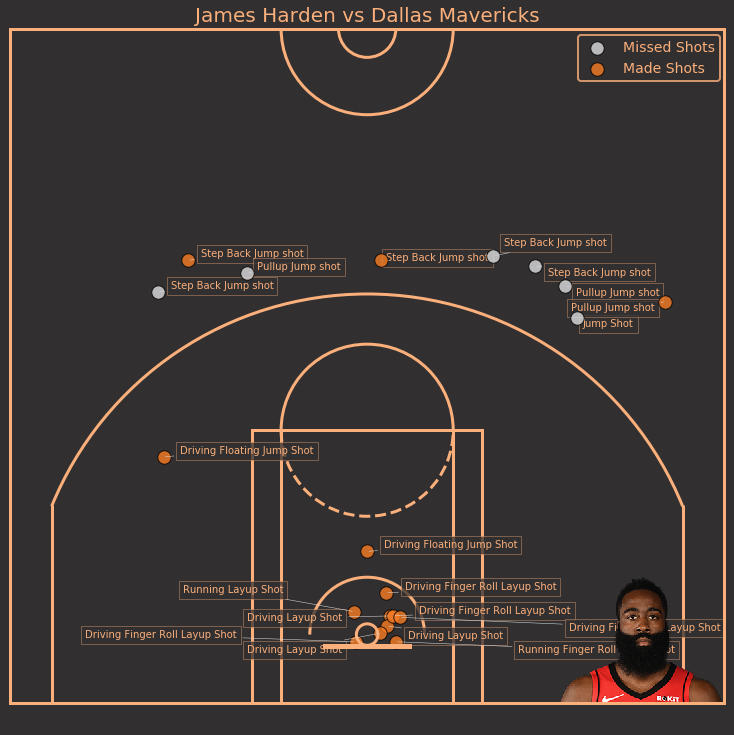

In [26]:
plot_raw_shotchart(data_frame=last_game, title="James Harden vs Dallas Mavericks", plot_types=True)

## Porzingis

In [27]:
player_id = find_players_by_full_name("Kristaps Porzingis")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

In [28]:
last_game = player_df.loc[player_df.GAME_ID == '0021901238']

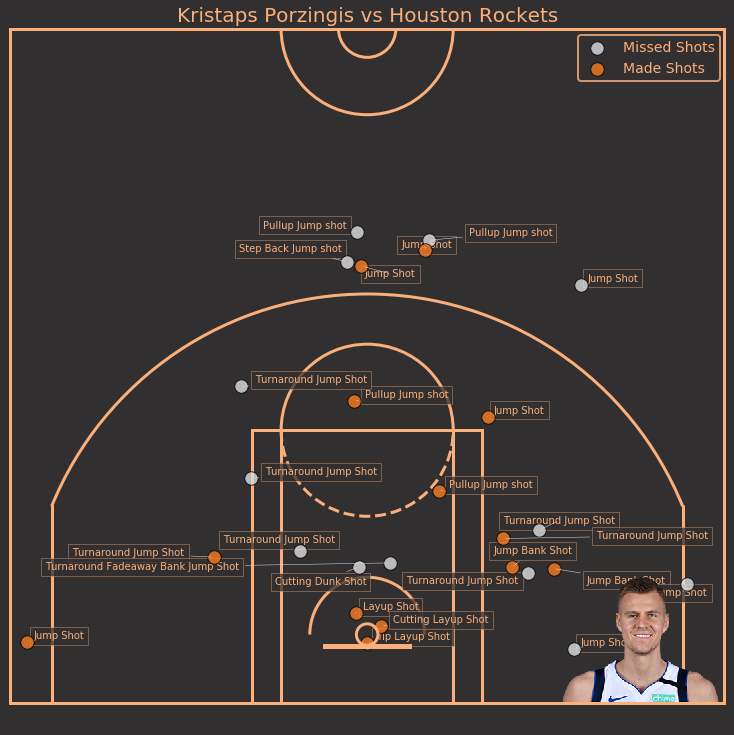

In [29]:
plot_raw_shotchart(data_frame=last_game, title="Kristaps Porzingis vs Houston Rockets", plot_types=True)

### TJ Warren

In [12]:
player_id = find_players_by_full_name("T.J. Warren")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

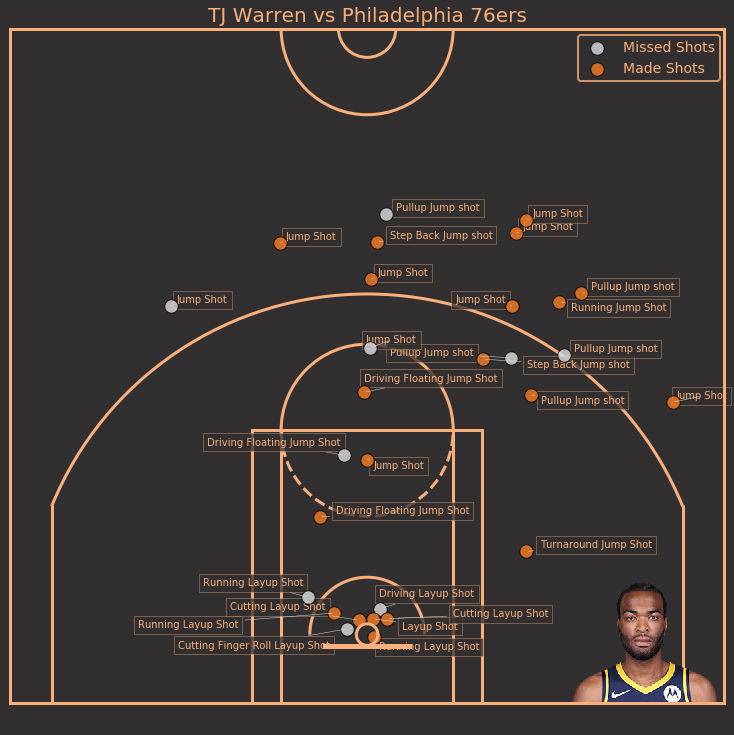

In [14]:
last_game = player_df.loc[player_df.GAME_ID == '0021901242']

plot_raw_shotchart(data_frame=last_game, title="TJ Warren vs Philadelphia 76ers", plot_types=True)

## Tucker and Green

In [5]:
player_id = find_players_by_full_name("P.J. Tucker")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

In [6]:
from nba_api.stats.static.teams import find_teams_by_full_name

In [9]:
rockets = find_teams_by_full_name("Houston Rockets")[0]['id']

In [11]:
team_shotchart = ShotChartDetail(team_id=rockets, player_id=0, context_measure_simple='FGA', season_nullable='2019-20')

In [18]:
team_df = team_shotchart.get_data_frames()[0]
team_df.LOC_X = -team_df.LOC_X

In [29]:
target_player_ids = [200782, 201145]  # PJ Tucker, Jeff Green

In [20]:
bucks_game = team_df.loc[team_df.GAME_ID == "0021901248"]

In [30]:
green_tucker = bucks_game.loc[bucks_game.PLAYER_ID.isin(target_player_ids)]

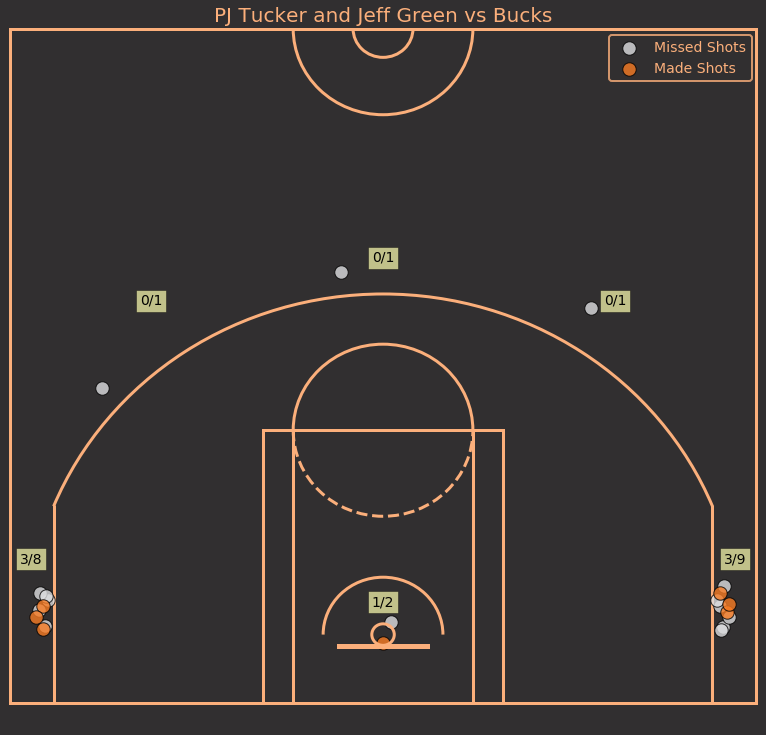

In [31]:
plot_raw_shotchart(data_frame=green_tucker, title="PJ Tucker and Jeff Green vs Bucks", plot_types=False, plot_attempts=True)

#### Westbrook shot chart

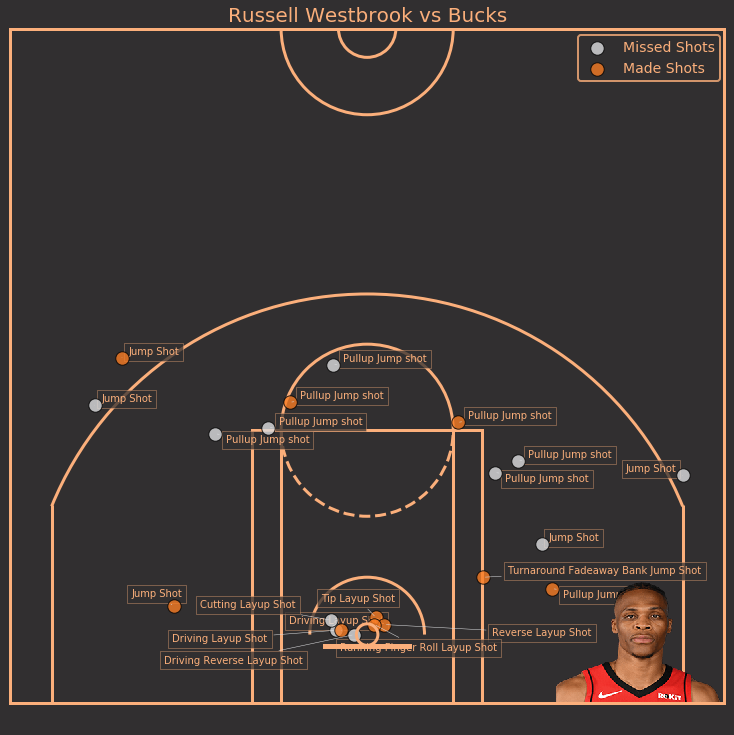

In [28]:
westbrook_id = "201566"

target_df = bucks_game.loc[bucks_game.PLAYER_ID == int(westbrook_id)]

plot_raw_shotchart(data_frame=target_df, title="Russell Westbrook vs Bucks", plot_types=True, plot_attempts=False, plot_image=True)

#### Giannis

In [32]:
bucks = find_teams_by_full_name("Milwaukee Bucks")[0]['id']

team_shotchart = ShotChartDetail(team_id=bucks, player_id=0, context_measure_simple='FGA', season_nullable='2019-20')

In [33]:
team_df = team_shotchart.get_data_frames()[0]
rockets_game = team_df.loc[team_df.GAME_ID == "0021901248"]

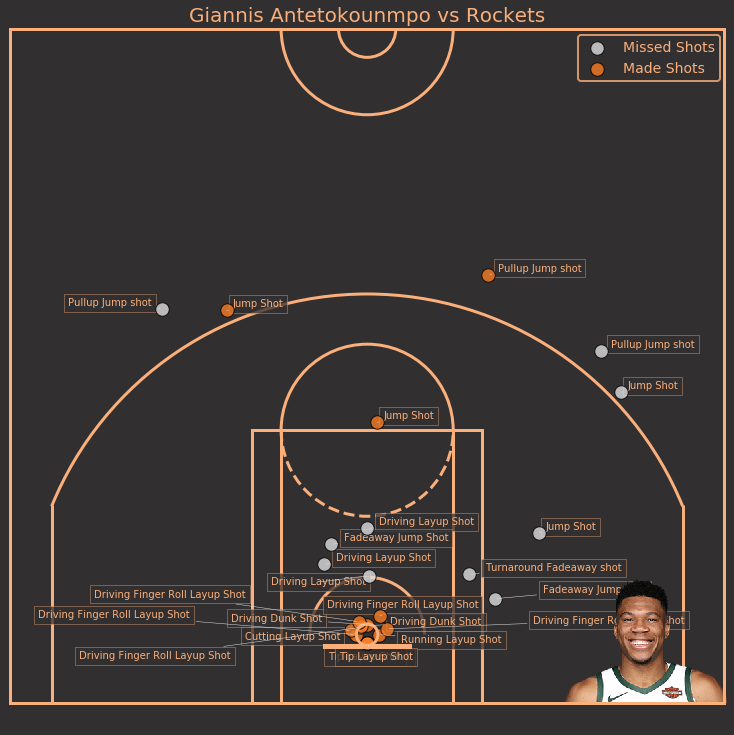

In [35]:
player_id = "203507"

target_df = rockets_game.loc[rockets_game.PLAYER_ID == int(player_id)]

plot_raw_shotchart(data_frame=target_df, title="Giannis Antetokounmpo vs Rockets", plot_types=True, plot_attempts=False, plot_image=True)

### Lopez

In [36]:
rockets_game

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
6012,Shot Chart Detail,0021901248,7,203114,Khris Middleton,1610612749,Milwaukee Bucks,1,11,46,...,Center(C),24+ ft.,25,-24,258,1,1,20200802,HOU,MIL
6013,Shot Chart Detail,0021901248,11,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,1,11,18,...,Right Side Center(RC),24+ ft.,26,84,251,1,1,20200802,HOU,MIL
6014,Shot Chart Detail,0021901248,17,201572,Brook Lopez,1610612749,Milwaukee Bucks,1,10,51,...,Left Side(L),24+ ft.,22,-228,6,1,0,20200802,HOU,MIL
6015,Shot Chart Detail,0021901248,21,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,1,10,12,...,Right Side(R),8-16 ft.,8,71,42,1,0,20200802,HOU,MIL
6016,Shot Chart Detail,0021901248,25,203114,Khris Middleton,1610612749,Milwaukee Bucks,1,9,37,...,Center(C),Less Than 8 ft.,1,-16,2,1,1,20200802,HOU,MIL
6017,Shot Chart Detail,0021901248,29,203114,Khris Middleton,1610612749,Milwaukee Bucks,1,9,19,...,Center(C),Less Than 8 ft.,1,-19,5,1,1,20200802,HOU,MIL
6018,Shot Chart Detail,0021901248,32,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,1,8,55,...,Center(C),Less Than 8 ft.,0,-8,0,1,1,20200802,HOU,MIL
6019,Shot Chart Detail,0021901248,37,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,1,8,51,...,Center(C),8-16 ft.,14,7,148,1,1,20200802,HOU,MIL
6020,Shot Chart Detail,0021901248,46,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,1,7,51,...,Left Side Center(LC),24+ ft.,26,-143,227,1,0,20200802,HOU,MIL
6021,Shot Chart Detail,0021901248,76,201572,Brook Lopez,1610612749,Milwaukee Bucks,1,6,32,...,Left Side(L),8-16 ft.,13,-131,36,1,1,20200802,HOU,MIL


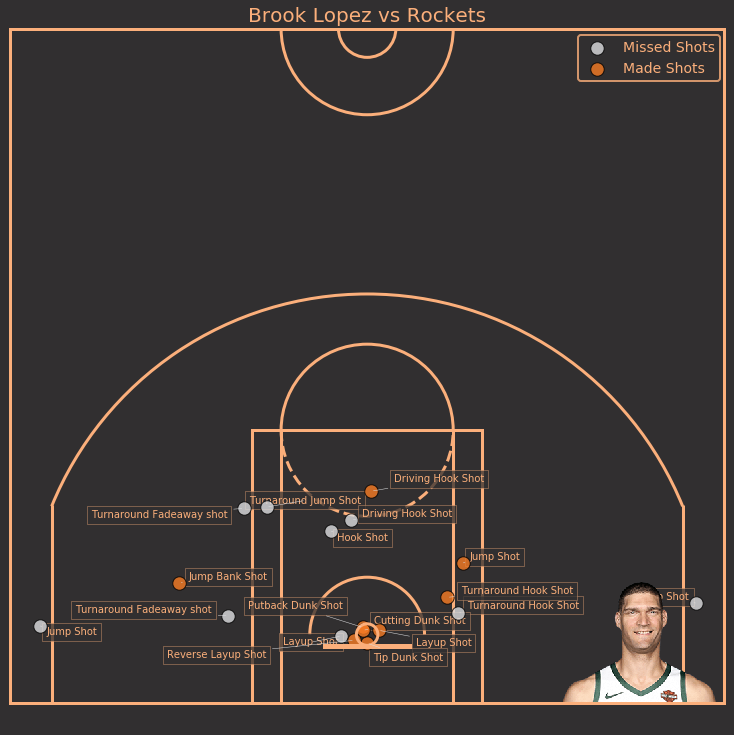

In [37]:
player_id = "201572"

target_df = rockets_game.loc[rockets_game.PLAYER_ID == int(player_id)]

plot_raw_shotchart(data_frame=target_df, title="Brook Lopez vs Rockets", plot_types=True, plot_attempts=False, plot_image=True)

#### Middleton

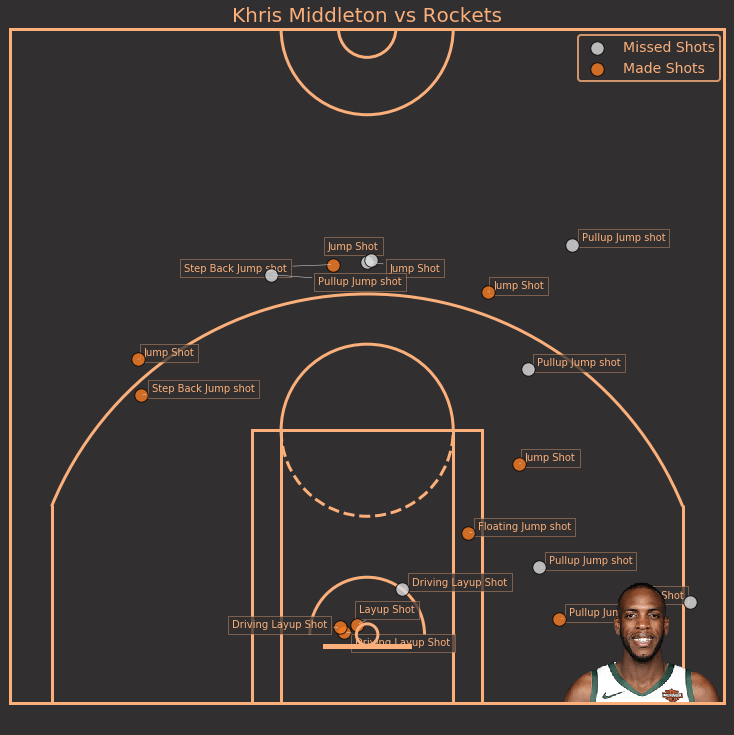

In [38]:
player_id = "203114"

target_df = rockets_game.loc[rockets_game.PLAYER_ID == int(player_id)]

plot_raw_shotchart(data_frame=target_df, title="Khris Middleton vs Rockets", plot_types=True, plot_attempts=False, plot_image=True)

### Fred Van Vleet

In [44]:
player_id = find_players_by_full_name("Fred VanVleet")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

In [45]:
player_df

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021900001,55,1627832,Fred VanVleet,1610612761,Toronto Raptors,1,7,32,...,Left Side Center(LC),24+ ft.,24,158,188,1,1,20191022,TOR,NOP
1,Shot Chart Detail,0021900001,86,1627832,Fred VanVleet,1610612761,Toronto Raptors,1,5,9,...,Center(C),Less Than 8 ft.,1,-14,4,1,1,20191022,TOR,NOP
2,Shot Chart Detail,0021900001,126,1627832,Fred VanVleet,1610612761,Toronto Raptors,1,3,22,...,Center(C),Less Than 8 ft.,1,14,4,1,1,20191022,TOR,NOP
3,Shot Chart Detail,0021900001,226,1627832,Fred VanVleet,1610612761,Toronto Raptors,2,8,32,...,Center(C),Less Than 8 ft.,1,9,13,1,1,20191022,TOR,NOP
4,Shot Chart Detail,0021900001,259,1627832,Fred VanVleet,1610612761,Toronto Raptors,2,7,11,...,Right Side Center(RC),24+ ft.,26,-138,228,1,1,20191022,TOR,NOP
5,Shot Chart Detail,0021900001,276,1627832,Fred VanVleet,1610612761,Toronto Raptors,2,6,11,...,Center(C),Less Than 8 ft.,2,-24,4,1,0,20191022,TOR,NOP
6,Shot Chart Detail,0021900001,295,1627832,Fred VanVleet,1610612761,Toronto Raptors,2,5,16,...,Center(C),Less Than 8 ft.,1,14,13,1,0,20191022,TOR,NOP
7,Shot Chart Detail,0021900001,322,1627832,Fred VanVleet,1610612761,Toronto Raptors,2,3,16,...,Left Side Center(LC),24+ ft.,27,109,251,1,0,20191022,TOR,NOP
8,Shot Chart Detail,0021900001,388,1627832,Fred VanVleet,1610612761,Toronto Raptors,3,11,37,...,Center(C),Less Than 8 ft.,1,15,13,1,1,20191022,TOR,NOP
9,Shot Chart Detail,0021900001,408,1627832,Fred VanVleet,1610612761,Toronto Raptors,3,9,38,...,Center(C),24+ ft.,26,42,260,1,1,20191022,TOR,NOP


### Bubble Goat

In [5]:
player_id = find_players_by_full_name("T.J. Warren")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

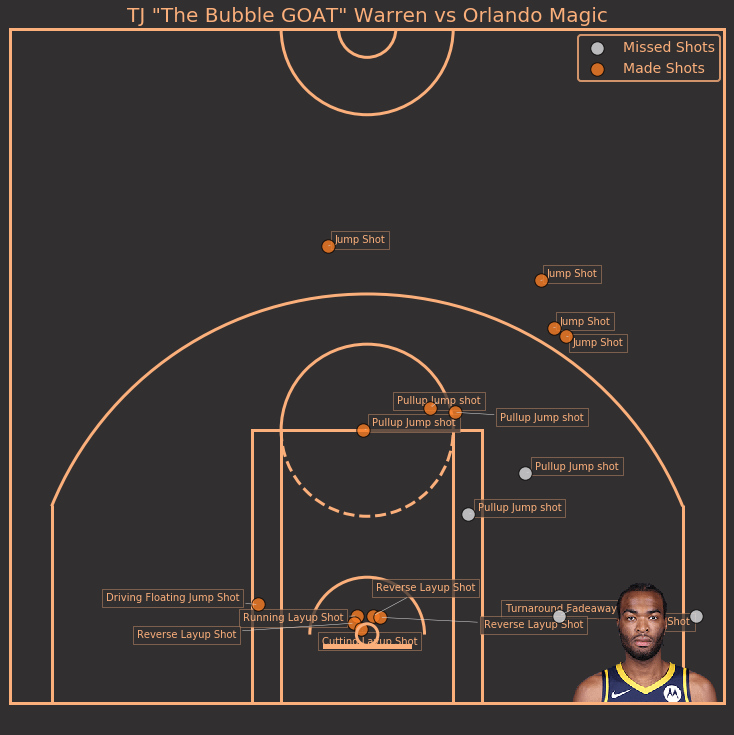

In [10]:
player_df = player_df.loc[player_df.GAME_ID == '0021901259']

plot_raw_shotchart(data_frame=player_df, title="TJ \"The Bubble GOAT\" Warren vs Orlando Magic", plot_types=True, plot_image=True)

#### Devin Booker

In [11]:
player_id = find_players_by_full_name("Devin Booker")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

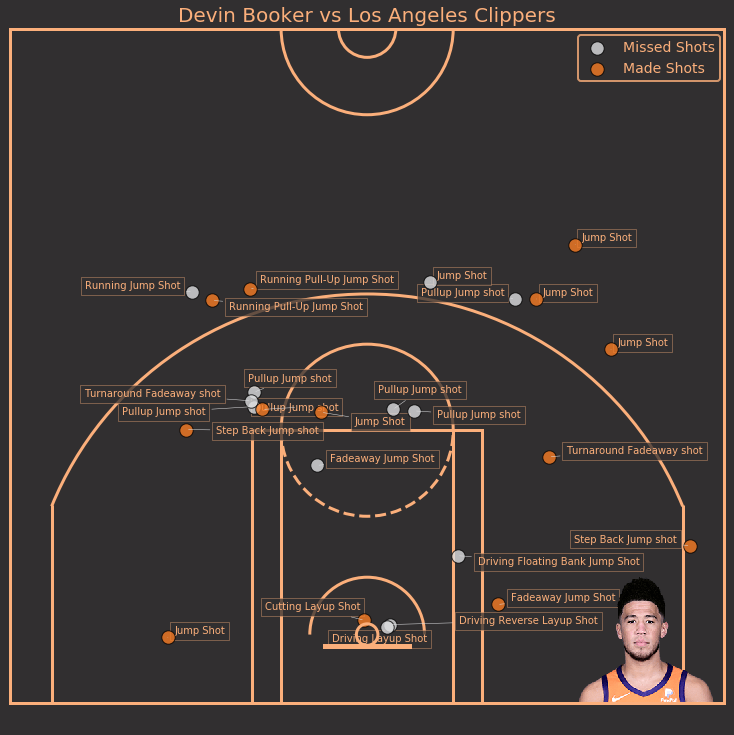

In [13]:
player_df = player_df.loc[player_df.GAME_ID == '0021901258']

plot_raw_shotchart(data_frame=player_df, title="Devin Booker vs Los Angeles Clippers", plot_types=True, plot_image=True)

### Damian Lillard


In [5]:
player_id = find_players_by_full_name("Damian Lillard")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

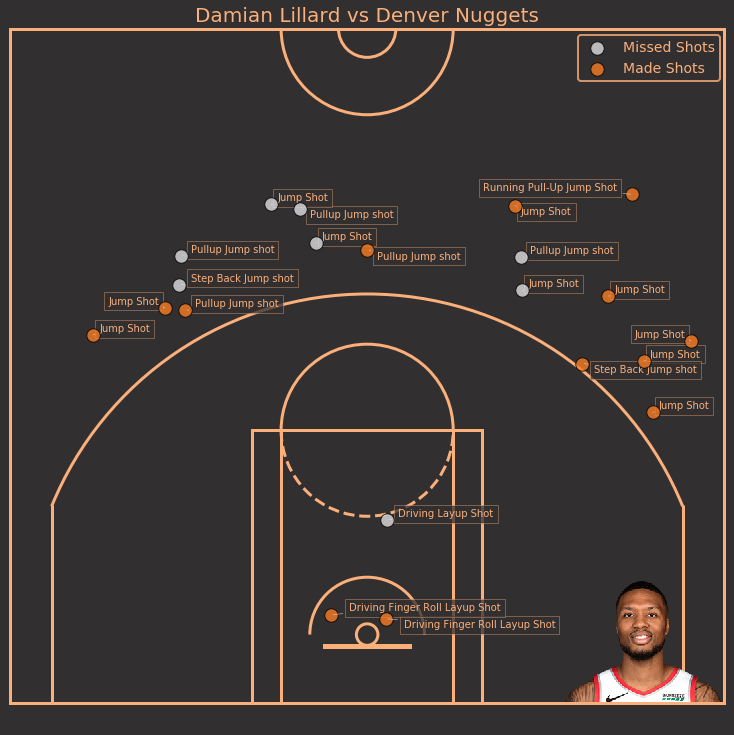

In [6]:
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]

plot_raw_shotchart(data_frame=player_df, title="Damian Lillard vs Denver Nuggets", plot_types=True, plot_image=True)

### Bogdan Bogdanović

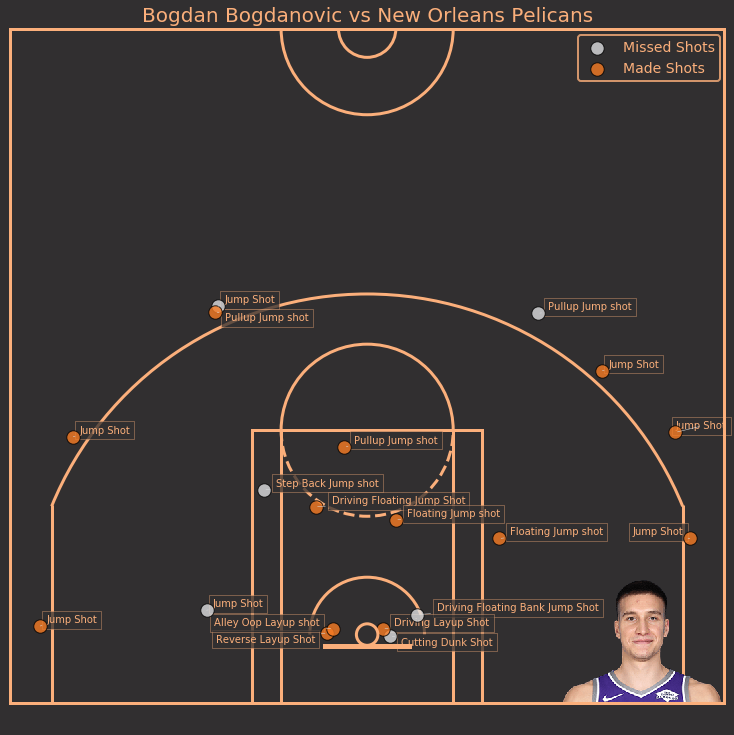

In [7]:
player_id = find_players_by_full_name("Bogdan Bogdanovic")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]

plot_raw_shotchart(data_frame=player_df, title="Bogdan Bogdanovic vs New Orleans Pelicans", plot_types=True, plot_image=True)

### LeBron

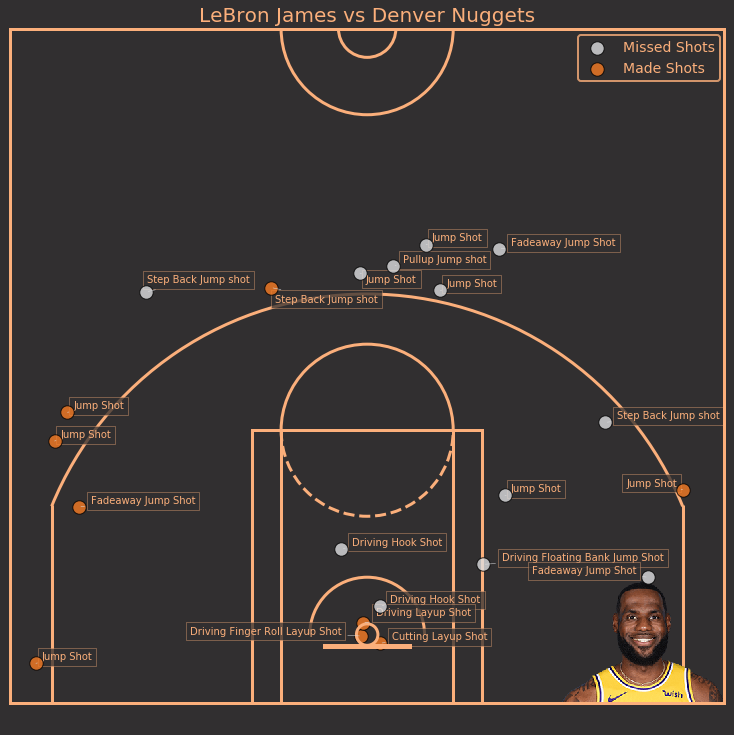

In [5]:
player_id = find_players_by_full_name("LeBron James")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]

plot_raw_shotchart(data_frame=player_df, title="LeBron James vs Denver Nuggets", plot_types=True, plot_image=True)

### Damian Lillard


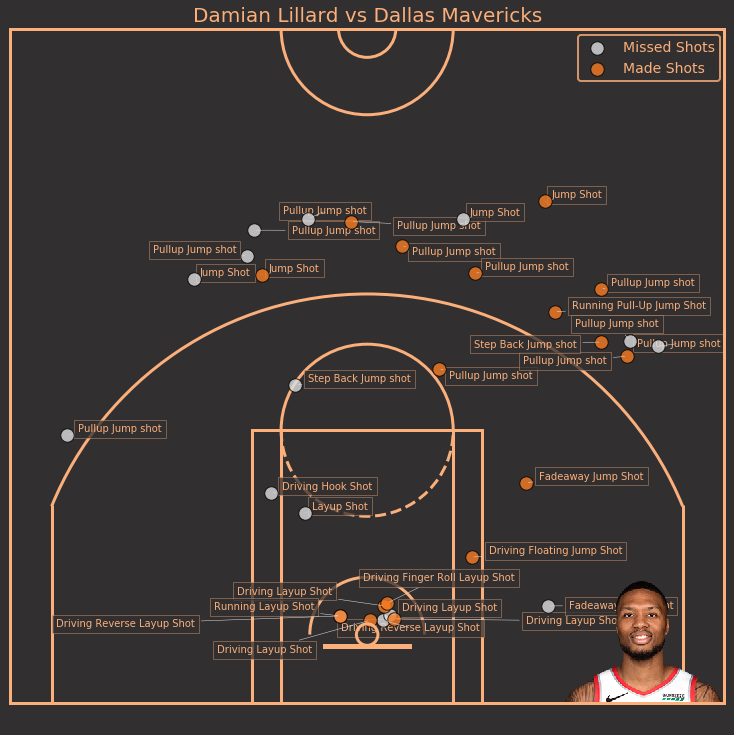

In [5]:
player_id = find_players_by_full_name("Damian Lillard")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]

plot_raw_shotchart(data_frame=player_df, title="Damian Lillard vs Dallas Mavericks", plot_types=True, plot_image=True)

### Donovan Mitchell


In [10]:
player_id = find_players_by_full_name("Donovan Mitchell")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

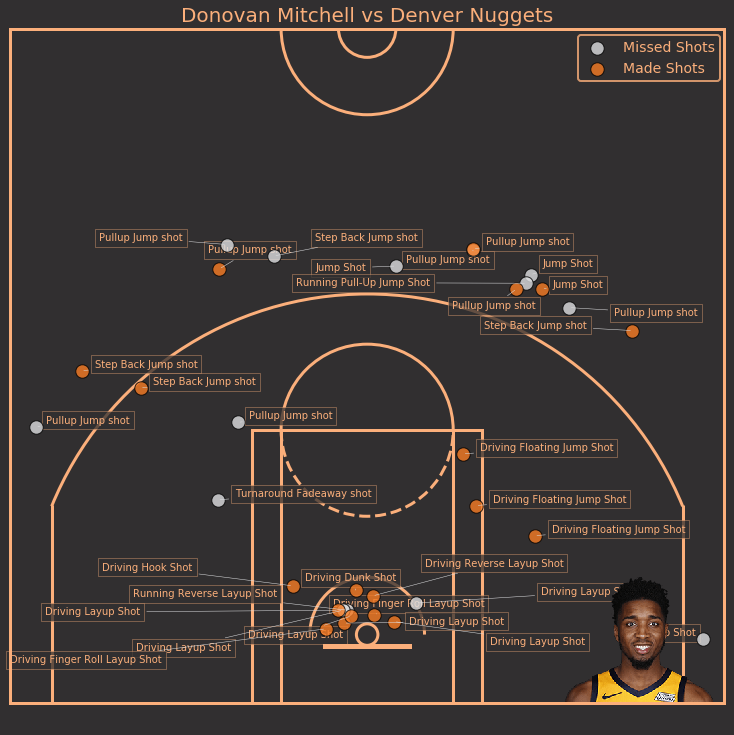

In [13]:
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]

plot_raw_shotchart(data_frame=player_df, title="Donovan Mitchell vs Denver Nuggets", plot_types=True, plot_image=True)

### Jamal Murray

In [14]:
player_id = find_players_by_full_name("Jamal Murray")[0]['id']

player_shotchart = ShotChartDetail(team_id=0, player_id=player_id, context_measure_simple='FGA', season_nullable='2019-20', season_type_all_star='Playoffs')

player_df = player_shotchart.get_data_frames()[0]

player_df.LOC_X = -player_df.LOC_X

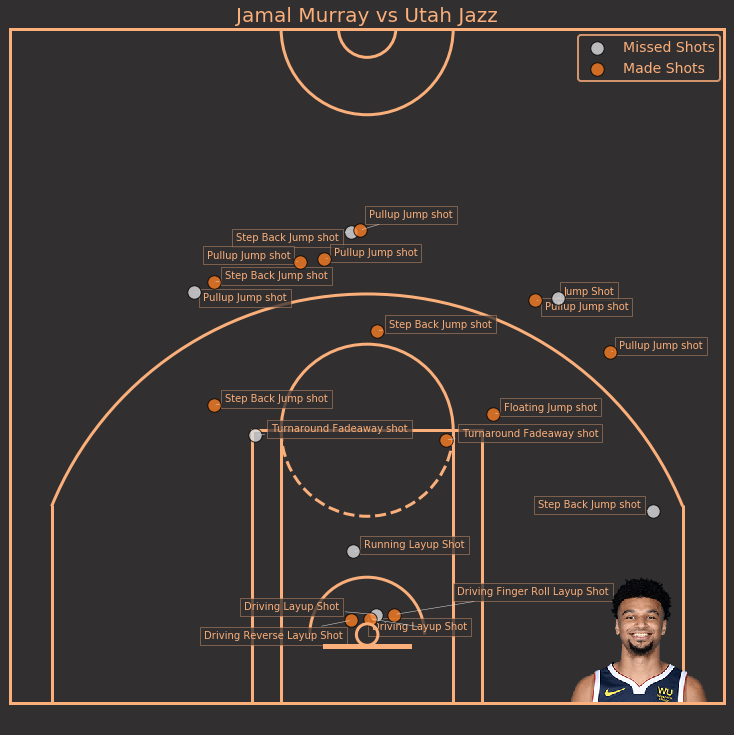

In [15]:
player_df = player_df.loc[player_df.GAME_ID == player_df.iloc[-1].GAME_ID]

plot_raw_shotchart(data_frame=player_df, title="Jamal Murray vs Utah Jazz", plot_types=True, plot_image=True)